In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Configuration
CONFIG = {
    'outcome': 'rent',  # 'rent' or 'pop'
    'test_years': [2023],
    'alpha': 10.0,  # Ridge regularization
}

print(f"Outcome: {CONFIG['outcome']}")
print(f"Test years: {CONFIG['test_years']}")

Outcome: rent
Test years: [2023]


## Load and Prepare Data

In [32]:
# Load data
rents = pd.read_csv('regression_data/median_rent_by_place.csv')
homes = pd.read_csv('regression_data/zillow_homeval_city.csv')
pop = pd.read_csv('regression_data/city_population.csv')

print(f"Rents: {rents.shape}")
print(f"Homes: {homes.shape}")
print(f"Population: {pop.shape}")

# Preview
pop.head()

Rents: (10279, 31)
Homes: (21461, 53)
Population: (10301, 51)


,City,State,2000,2001,2002,2003,2004,2005,2006,2007,...,2015_yoy,2016_yoy,2017_yoy,2018_yoy,2019_yoy,2020_yoy,2021_yoy,2022_yoy,2023_yoy,2024_yoy
0,Abbeville,AL,2985.0,2941.0,2909.0,2882.0,2857.0,2820.0,2807.0,2784.0,...,-0.011094,-0.014423,-0.011382,-0.013980,-0.012927,-0.007605,-0.008514,-0.000429,0.003866,0.014121
1,Abbeville,GA,2315.0,2437.0,2426.0,2474.0,2529.0,2493.0,2587.0,2583.0,...,0.024441,-0.054192,0.005766,0.004658,-0.039586,0.017081,-0.018985,0.023074,0.038559,-0.003503
2,Abbeville,LA,12059.0,12018.0,12043.0,12002.0,12015.0,12104.0,12159.0,12189.0,...,-0.006066,-0.005935,-0.016147,-0.011796,-0.018165,-0.016298,-0.007344,-0.011458,-0.003742,-0.001283
3,Abbeville,SC,5896.0,5865.0,5812.0,5761.0,5696.0,5593.0,5510.0,5443.0,...,-0.006131,-0.009353,-0.005223,-0.002827,-0.005670,-0.010794,-0.001853,0.002682,0.003086,-0.001231
4,Abbotsford,WI,1982.0,2011.0,2043.0,2078.0,2113.0,2148.0,2185.0,2220.0,...,-0.004783,-0.000437,0.003934,0.003483,-0.005206,0.000872,-0.002179,-0.003930,0.033319,0.028002


In [33]:
# Identify year columns
rent_year_cols = [c for c in rents.columns if c.isdigit() and int(c) >= 2009]
home_year_cols = [c for c in homes.columns if c.isdigit() and int(c) >= 2009]
pop_year_cols = [c for c in pop.columns if c.isdigit() and int(c) >= 2009]

print(f"Rent years: {rent_year_cols}")
print(f"Home years: {home_year_cols}")
print(f"Pop years: {pop_year_cols}")

Rent years: ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
Home years: ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025']
Pop years: ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']


In [34]:
# Merge datasets
# Standardize city/state columns
rents = rents.rename(columns={'RegionName': 'City', 'StateName': 'State'})
homes = homes.rename(columns={'RegionName': 'City', 'StateName': 'State'})

# Rename year columns with suffix
rent_renamed = {c: f"{c}_rent" for c in rent_year_cols}
home_renamed = {c: f"{c}_home" for c in home_year_cols}
pop_renamed = {c: f"{c}_pop" for c in pop_year_cols}

rents = rents.rename(columns=rent_renamed)
homes = homes.rename(columns=home_renamed)
pop = pop.rename(columns=pop_renamed)
# Merge
merged = rents.merge(homes, on=['City', 'State'], how='inner')
merged = merged.merge(pop, on=['City', 'State'], how='inner')

print(f"Merged dataset: {merged.shape}")
print(f"Cities: {len(merged)}")
merged.head()

Merged dataset: (8343, 131)
Cities: 8343


,City,State,2009_rent,2010_rent,2011_rent,2012_rent,2013_rent,2014_rent,2015_rent,2016_rent,...,2015_yoy,2016_yoy,2017_yoy,2018_yoy,2019_yoy,2020_yoy,2021_yoy,2022_yoy,2023_yoy,2024_yoy_y
0,Abbeville,AL,525.0,488.0,477.0,469.0,495.0,508.0,493.0,514.0,...,-0.011094,-0.014423,-0.011382,-0.013980,-0.012927,-0.007605,-0.008514,-0.000429,0.003866,0.014121
1,Abbeville,GA,340.0,367.0,457.0,398.0,430.0,411.0,411.0,350.0,...,0.024441,-0.054192,0.005766,0.004658,-0.039586,0.017081,-0.018985,0.023074,0.038559,-0.003503
2,Abbeville,LA,544.0,543.0,595.0,574.0,596.0,627.0,622.0,647.0,...,-0.006066,-0.005935,-0.016147,-0.011796,-0.018165,-0.016298,-0.007344,-0.011458,-0.003742,-0.001283
3,Abbeville,SC,526.0,520.0,544.0,613.0,678.0,491.0,486.0,497.0,...,-0.006131,-0.009353,-0.005223,-0.002827,-0.005670,-0.010794,-0.001853,0.002682,0.003086,-0.001231
4,Abbotsford,WI,527.0,536.0,572.0,573.0,587.0,550.0,603.0,493.0,...,-0.004783,-0.000437,0.003934,0.003483,-0.005206,0.000872,-0.002179,-0.003930,0.033319,0.028002


In [35]:
# Define common years (intersection of all datasets)
rent_years = [int(c.replace('_rent', '')) for c in merged.columns if c.endswith('_rent')]
home_years = [int(c.replace('_home', '')) for c in merged.columns if c.endswith('_home')]
pop_years_raw = [c.replace('_pop', '') for c in merged.columns if c.endswith('_pop')]
pop_years = [int(y) for y in pop_years_raw if y.isdigit()]

common_years = sorted(set(rent_years) & set(home_years) & set(pop_years))
print(f"Common years: {common_years}")

# Years for which we can compute YoY (need t and t-1)
yoy_years = [y for y in common_years if y-1 in common_years]
print(f"YoY years: {yoy_years}")

Common years: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
YoY years: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


## Build Panel Data with All Three Representations

In [36]:
# Build panel data with levels, log-levels, and growth rates (with 3 years of lags)
panel_data = []

def safe_growth(curr, prev):
    """Compute growth rate safely, return NaN if invalid"""
    if pd.isna(curr) or pd.isna(prev) or prev <= 0:
        return np.nan
    return (curr - prev) / prev * 100

def safe_log(val):
    """Compute log safely, return NaN if invalid"""
    if pd.isna(val) or val <= 0:
        return np.nan
    return np.log(val)

for idx, row in merged.iterrows():
    city = row['City']
    state = row['State']
    
    for year in yoy_years:
        # Get current and lagged values (up to 3 years back)
        rent_t = row.get(f'{year}_rent', np.nan)
        rent_t1 = row.get(f'{year-1}_rent', np.nan)
        rent_t2 = row.get(f'{year-2}_rent', np.nan)
        rent_t3 = row.get(f'{year-3}_rent', np.nan)
        
        home_t = row.get(f'{year}_home', np.nan)
        home_t1 = row.get(f'{year-1}_home', np.nan)
        home_t2 = row.get(f'{year-2}_home', np.nan)
        home_t3 = row.get(f'{year-3}_home', np.nan)
        
        pop_t = row.get(f'{year}_pop', np.nan)
        pop_t1 = row.get(f'{year-1}_pop', np.nan)
        pop_t2 = row.get(f'{year-2}_pop', np.nan)
        pop_t3 = row.get(f'{year-3}_pop', np.nan)
        
        # Skip if missing current or lag1 values
        if any(pd.isna([rent_t, rent_t1, home_t, home_t1, pop_t, pop_t1])):
            continue
        if any(v <= 0 for v in [rent_t, rent_t1, home_t, home_t1, pop_t, pop_t1]):
            continue
        
        # Compute growth rates (YoY %)
        rent_growth = safe_growth(rent_t, rent_t1)
        rent_growth_lag1 = safe_growth(rent_t1, rent_t2)
        rent_growth_lag2 = safe_growth(rent_t2, rent_t3)
        
        home_growth = safe_growth(home_t, home_t1)
        home_growth_lag1 = safe_growth(home_t1, home_t2)
        home_growth_lag2 = safe_growth(home_t2, home_t3)
        
        pop_growth = safe_growth(pop_t, pop_t1)
        pop_growth_lag1 = safe_growth(pop_t1, pop_t2)
        pop_growth_lag2 = safe_growth(pop_t2, pop_t3)
        
        panel_data.append({
            'City': city,
            'State': state,
            'Year': year,
            # Raw levels (current + 3 lags)
            'rent_level': rent_t,
            'rent_level_lag1': rent_t1,
            'rent_level_lag2': rent_t2,
            'rent_level_lag3': rent_t3,
            'home_level': home_t,
            'home_level_lag1': home_t1,
            'home_level_lag2': home_t2,
            'home_level_lag3': home_t3,
            'pop_level': pop_t,
            'pop_level_lag1': pop_t1,
            'pop_level_lag2': pop_t2,
            'pop_level_lag3': pop_t3,
            # Log-levels (current + 3 lags)
            'rent_log': safe_log(rent_t),
            'rent_log_lag1': safe_log(rent_t1),
            'rent_log_lag2': safe_log(rent_t2),
            'rent_log_lag3': safe_log(rent_t3),
            'home_log': safe_log(home_t),
            'home_log_lag1': safe_log(home_t1),
            'home_log_lag2': safe_log(home_t2),
            'home_log_lag3': safe_log(home_t3),
            'pop_log': safe_log(pop_t),
            'pop_log_lag1': safe_log(pop_t1),
            'pop_log_lag2': safe_log(pop_t2),
            'pop_log_lag3': safe_log(pop_t3),
            # Growth rates (current + 2 lagged growth rates = 3 years of info)
            'rent_growth': rent_growth,
            'rent_growth_lag1': rent_growth_lag1,
            'rent_growth_lag2': rent_growth_lag2,
            'home_growth': home_growth,
            'home_growth_lag1': home_growth_lag1,
            'home_growth_lag2': home_growth_lag2,
            'pop_growth': pop_growth,
            'pop_growth_lag1': pop_growth_lag1,
            'pop_growth_lag2': pop_growth_lag2,
        })

panel_df = pd.DataFrame(panel_data)

# Drop rows with any NaN in key columns (due to missing lags)
key_cols = [c for c in panel_df.columns if 'level' in c or 'log' in c or 'growth' in c]
panel_df = panel_df.dropna(subset=key_cols)

print(f"Panel shape: {panel_df.shape}")
print(f"Years: {sorted(panel_df['Year'].unique())}")
print(f"Cities: {panel_df['City'].nunique()}")

Panel shape: (95009, 21)
Years: [np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
Cities: 5879


In [37]:
# Add state fixed effects
state_dummies = pd.get_dummies(panel_df['State'], prefix='state', drop_first=True).astype(int)
panel_df = pd.concat([panel_df.reset_index(drop=True), state_dummies.reset_index(drop=True)], axis=1)
state_dummy_cols = list(state_dummies.columns)

print(f"Added {len(state_dummy_cols)} state dummies")
panel_df.head()

Added 49 state dummies


,City,State,Year,rent_level,rent_level_lag,home_level,home_level_lag,pop_level,pop_level_lag,rent_log,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,Abbeville,AL,2010,488.0,525.0,104895.582175,103336.928740,2693.0,2714.0,6.190315,...,0,0,0,0,0,0,0,0,0,0
1,Abbeville,AL,2011,477.0,488.0,98548.372831,104895.582175,2668.0,2693.0,6.167516,...,0,0,0,0,0,0,0,0,0,0
2,Abbeville,AL,2012,469.0,477.0,99709.314736,98548.372831,2600.0,2668.0,6.150603,...,0,0,0,0,0,0,0,0,0,0
3,Abbeville,AL,2013,495.0,469.0,99368.919839,99709.314736,2562.0,2600.0,6.204558,...,0,0,0,0,0,0,0,0,0,0
4,Abbeville,AL,2014,508.0,495.0,102355.053306,99368.919839,2524.0,2562.0,6.230481,...,0,0,0,0,0,0,0,0,0,0


## Compare Target Distributions

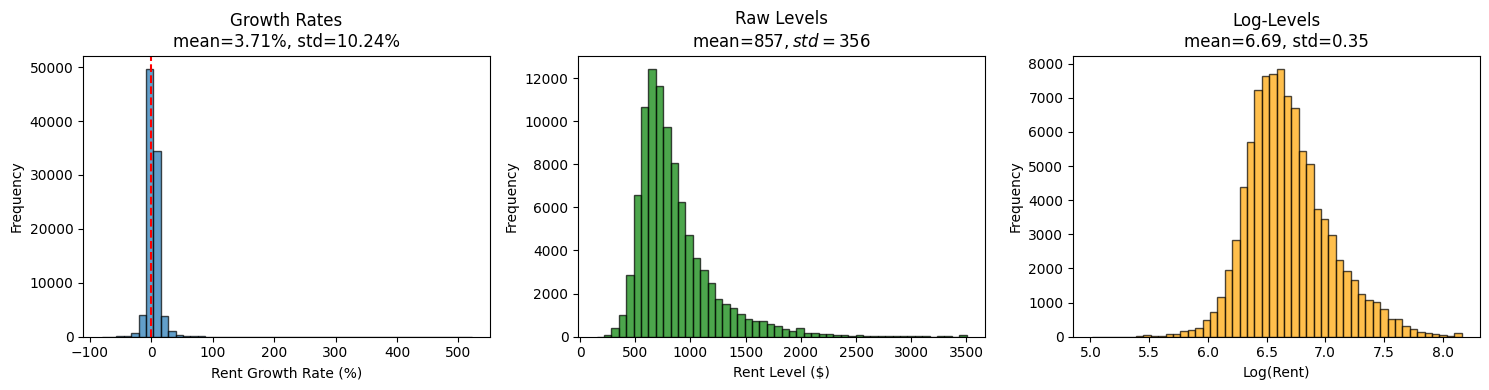


Coefficient of Variation (std/|mean|) - higher means more relative variance:
  Growth rates: 2.76
  Raw levels:   0.41
  Log-levels:   0.05


In [38]:
# Visualize the three target representations
outcome = CONFIG['outcome']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Growth rates
axes[0].hist(panel_df[f'{outcome}_growth'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--')
axes[0].set_xlabel(f'{outcome.title()} Growth Rate (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Growth Rates\nmean={panel_df[f"{outcome}_growth"].mean():.2f}%, std={panel_df[f"{outcome}_growth"].std():.2f}%')

# Raw levels
axes[1].hist(panel_df[f'{outcome}_level'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel(f'{outcome.title()} Level ($)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Raw Levels\nmean=${panel_df[f"{outcome}_level"].mean():,.0f}, std=${panel_df[f"{outcome}_level"].std():,.0f}')

# Log-levels
axes[2].hist(panel_df[f'{outcome}_log'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[2].set_xlabel(f'Log({outcome.title()})')
axes[2].set_ylabel('Frequency')
axes[2].set_title(f'Log-Levels\nmean={panel_df[f"{outcome}_log"].mean():.2f}, std={panel_df[f"{outcome}_log"].std():.2f}')

plt.tight_layout()
plt.show()

# Print coefficient of variation (std/mean) - higher = more signal
print("\nCoefficient of Variation (std/|mean|) - higher means more relative variance:")
print(f"  Growth rates: {panel_df[f'{outcome}_growth'].std() / abs(panel_df[f'{outcome}_growth'].mean()):.2f}")
print(f"  Raw levels:   {panel_df[f'{outcome}_level'].std() / panel_df[f'{outcome}_level'].mean():.2f}")
print(f"  Log-levels:   {panel_df[f'{outcome}_log'].std() / panel_df[f'{outcome}_log'].mean():.2f}")

## Train/Test Split

In [39]:
# Split by year
train_df = panel_df[~panel_df['Year'].isin(CONFIG['test_years'])].copy()
test_df = panel_df[panel_df['Year'].isin(CONFIG['test_years'])].copy()

print(f"Train: {len(train_df)} observations (years {sorted(train_df['Year'].unique())})")
print(f"Test: {len(test_df)} observations (years {sorted(test_df['Year'].unique())})")

Train: 87246 observations (years [np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)])
Test: 7763 observations (years [np.int64(2023)])


## Approach 1: Predict Growth Rates

In [ ]:
# Predict growth rate from lagged growth rates + state FE (3 years of lags)
outcome = CONFIG['outcome']

# Define features and target (with 3 years of lags)
if outcome == 'rent':
    feature_cols_growth = [
        'rent_growth_lag1', 'rent_growth_lag2',
        'home_growth', 'home_growth_lag1', 'home_growth_lag2',
        'pop_growth', 'pop_growth_lag1', 'pop_growth_lag2'
    ]
else:
    feature_cols_growth = [
        'pop_growth_lag1', 'pop_growth_lag2',
        'rent_growth', 'rent_growth_lag1', 'rent_growth_lag2',
        'home_growth', 'home_growth_lag1', 'home_growth_lag2'
    ]

all_features_growth = feature_cols_growth + state_dummy_cols
target_growth = f'{outcome}_growth'

# Prepare data
X_train_growth = train_df[all_features_growth].astype(float).values
y_train_growth = train_df[target_growth].astype(float).values
X_test_growth = test_df[all_features_growth].astype(float).values
y_test_growth = test_df[target_growth].astype(float).values

# Scale and fit
scaler_growth = StandardScaler()
X_train_growth_scaled = scaler_growth.fit_transform(X_train_growth)
X_test_growth_scaled = scaler_growth.transform(X_test_growth)

model_growth = Ridge(alpha=CONFIG['alpha'])
model_growth.fit(X_train_growth_scaled, y_train_growth)

# Predict
y_pred_train_growth = model_growth.predict(X_train_growth_scaled)
y_pred_test_growth = model_growth.predict(X_test_growth_scaled)

# Metrics
growth_results = {
    'train_r2': r2_score(y_train_growth, y_pred_train_growth),
    'test_r2': r2_score(y_test_growth, y_pred_test_growth),
    'train_rmse': np.sqrt(mean_squared_error(y_train_growth, y_pred_train_growth)),
    'test_rmse': np.sqrt(mean_squared_error(y_test_growth, y_pred_test_growth)),
    'train_mae': mean_absolute_error(y_train_growth, y_pred_train_growth),
    'test_mae': mean_absolute_error(y_test_growth, y_pred_test_growth),
}

print("=" * 50)

print("APPROACH 1: Predict Growth Rates")print(f"Test RMSE:  {growth_results['test_rmse']:.4f}")

print("=" * 50)print(f"\nTrain RMSE: {growth_results['train_rmse']:.4f}")

print(f"Target: {target_growth}")print(f"Test R²:  {growth_results['test_r2']:.4f}")

print(f"Features: {feature_cols_growth}")print(f"\nTrain R²: {growth_results['train_r2']:.4f}")

APPROACH 1: Predict Growth Rates
Target: rent_growth
Features: ['rent_growth_lag', 'home_growth', 'home_growth_lag', 'pop_growth', 'pop_growth_lag']

Train R²: 0.0212
Test R²:  -0.0102

Train RMSE: 10.0974
Test RMSE:  10.6137


## Approach 2: Predict Raw Levels

In [ ]:
# Predict level from lagged levels + state FE (3 years of lags)
if outcome == 'rent':
    feature_cols_level = [
        'rent_level_lag1', 'rent_level_lag2', 'rent_level_lag3',
        'home_level', 'home_level_lag1', 'home_level_lag2', 'home_level_lag3',
        'pop_level', 'pop_level_lag1', 'pop_level_lag2', 'pop_level_lag3'
    ]
else:
    feature_cols_level = [
        'pop_level_lag1', 'pop_level_lag2', 'pop_level_lag3',
        'rent_level', 'rent_level_lag1', 'rent_level_lag2', 'rent_level_lag3',
        'home_level', 'home_level_lag1', 'home_level_lag2', 'home_level_lag3'
    ]

all_features_level = feature_cols_level + state_dummy_cols
target_level = f'{outcome}_level'

# Prepare data
X_train_level = train_df[all_features_level].astype(float).values
y_train_level = train_df[target_level].astype(float).values
X_test_level = test_df[all_features_level].astype(float).values
y_test_level = test_df[target_level].astype(float).values

# Scale and fit
scaler_level = StandardScaler()
X_train_level_scaled = scaler_level.fit_transform(X_train_level)
X_test_level_scaled = scaler_level.transform(X_test_level)

model_level = Ridge(alpha=CONFIG['alpha'])
model_level.fit(X_train_level_scaled, y_train_level)

# Predict
y_pred_train_level = model_level.predict(X_train_level_scaled)
y_pred_test_level = model_level.predict(X_test_level_scaled)

# Metrics
level_results = {
    'train_r2': r2_score(y_train_level, y_pred_train_level),
    'test_r2': r2_score(y_test_level, y_pred_test_level),
    'train_rmse': np.sqrt(mean_squared_error(y_train_level, y_pred_train_level)),
    'test_rmse': np.sqrt(mean_squared_error(y_test_level, y_pred_test_level)),
    'train_mae': mean_absolute_error(y_train_level, y_pred_train_level),
    'test_mae': mean_absolute_error(y_test_level, y_pred_test_level),
}

print("=" * 50)

print("APPROACH 2: Predict Raw Levels")print(f"Test RMSE:  ${level_results['test_rmse']:,.2f}")

print("=" * 50)print(f"\nTrain RMSE: ${level_results['train_rmse']:,.2f}")

print(f"Target: {target_level}")print(f"Test R²:  {level_results['test_r2']:.4f}")

print(f"Features: {feature_cols_level}")print(f"\nTrain R²: {level_results['train_r2']:.4f}")

APPROACH 2: Predict Raw Levels
Target: rent_level
Features: ['rent_level_lag', 'home_level', 'home_level_lag', 'pop_level', 'pop_level_lag']

Train R²: 0.9507
Test R²:  0.9515

Train RMSE: $75.38
Test RMSE:  $101.01


## Approach 3: Predict Log-Levels

In [ ]:
# Predict log-level from lagged log-levels + state FE (3 years of lags)
if outcome == 'rent':
    feature_cols_log = [
        'rent_log_lag1', 'rent_log_lag2', 'rent_log_lag3',
        'home_log', 'home_log_lag1', 'home_log_lag2', 'home_log_lag3',
        'pop_log', 'pop_log_lag1', 'pop_log_lag2', 'pop_log_lag3'
    ]
else:
    feature_cols_log = [
        'pop_log_lag1', 'pop_log_lag2', 'pop_log_lag3',
        'rent_log', 'rent_log_lag1', 'rent_log_lag2', 'rent_log_lag3',
        'home_log', 'home_log_lag1', 'home_log_lag2', 'home_log_lag3'
    ]

all_features_log = feature_cols_log + state_dummy_cols
target_log = f'{outcome}_log'

# Prepare data
X_train_log = train_df[all_features_log].astype(float).values
y_train_log = train_df[target_log].astype(float).values
X_test_log = test_df[all_features_log].astype(float).values
y_test_log = test_df[target_log].astype(float).values

# Scale and fit
scaler_log = StandardScaler()
X_train_log_scaled = scaler_log.fit_transform(X_train_log)
X_test_log_scaled = scaler_log.transform(X_test_log)

model_log = Ridge(alpha=CONFIG['alpha'])
model_log.fit(X_train_log_scaled, y_train_log)

# Predict
y_pred_train_log = model_log.predict(X_train_log_scaled)
y_pred_test_log = model_log.predict(X_test_log_scaled)

# Metrics in log space
log_results = {
    'train_r2': r2_score(y_train_log, y_pred_train_log),
    'test_r2': r2_score(y_test_log, y_pred_test_log),
    'train_rmse': np.sqrt(mean_squared_error(y_train_log, y_pred_train_log)),
    'test_rmse': np.sqrt(mean_squared_error(y_test_log, y_pred_test_log)),
    'train_mae': mean_absolute_error(y_train_log, y_pred_train_log),
    'test_mae': mean_absolute_error(y_test_log, y_pred_test_log),
}

# Also compute metrics in original scale (exponentiate predictions)
y_pred_train_log_exp = np.exp(y_pred_train_log)
y_pred_test_log_exp = np.exp(y_pred_test_log)
y_train_level_from_log = train_df[f'{outcome}_level'].values
y_test_level_from_log = test_df[f'{outcome}_level'].values

log_results_original_scale = {
    'train_r2': r2_score(y_train_level_from_log, y_pred_train_log_exp),
    'test_r2': r2_score(y_test_level_from_log, y_pred_test_log_exp),
    'train_rmse': np.sqrt(mean_squared_error(y_train_level_from_log, y_pred_train_log_exp)),
    'test_rmse': np.sqrt(mean_squared_error(y_test_level_from_log, y_pred_test_log_exp)),
}

print("=" * 50)
print("APPROACH 3: Predict Log-Levels")
print("=" * 50)
print(f"Target: {target_log}")
print(f"Features: {feature_cols_log}")
print(f"\n--- Metrics in Log Space ---")
print(f"Train R²: {log_results['train_r2']:.4f}")

print(f"Test R²:  {log_results['test_r2']:.4f}")print(f"Test RMSE:  ${log_results_original_scale['test_rmse']:,.2f}")

print(f"Train RMSE: {log_results['train_rmse']:.4f}")print(f"Train RMSE: ${log_results_original_scale['train_rmse']:,.2f}")

print(f"Test RMSE:  {log_results['test_rmse']:.4f}")print(f"Test R²:  {log_results_original_scale['test_r2']:.4f}")

print(f"\n--- Metrics in Original Scale (after exp transform) ---")print(f"Train R²: {log_results_original_scale['train_r2']:.4f}")

APPROACH 3: Predict Log-Levels
Target: rent_log
Features: ['rent_log_lag', 'home_log', 'home_log_lag', 'pop_log', 'pop_log_lag']

--- Metrics in Log Space ---
Train R²: 0.9350
Test R²:  0.9343
Train RMSE: 0.0882
Test RMSE:  0.0963

--- Metrics in Original Scale (after exp transform) ---
Train R²: 0.9512
Test R²:  0.9513
Train RMSE: $75.00
Test RMSE:  $101.28


## Compare All Approaches

In [43]:
# Summary comparison
comparison = pd.DataFrame({
    'Approach': ['Growth Rates', 'Raw Levels', 'Log-Levels', 'Log-Levels (orig scale)'],
    'Train R²': [
        growth_results['train_r2'],
        level_results['train_r2'],
        log_results['train_r2'],
        log_results_original_scale['train_r2']
    ],
    'Test R²': [
        growth_results['test_r2'],
        level_results['test_r2'],
        log_results['test_r2'],
        log_results_original_scale['test_r2']
    ],
    'Overfitting (Train-Test R²)': [
        growth_results['train_r2'] - growth_results['test_r2'],
        level_results['train_r2'] - level_results['test_r2'],
        log_results['train_r2'] - log_results['test_r2'],
        log_results_original_scale['train_r2'] - log_results_original_scale['test_r2']
    ],
})

print("\n" + "=" * 70)
print("COMPARISON SUMMARY")
print("=" * 70)
print(comparison.to_string(index=False))


COMPARISON SUMMARY
               Approach  Train R²   Test R²  Overfitting (Train-Test R²)
           Growth Rates  0.021169 -0.010167                     0.031337
             Raw Levels  0.950732  0.951510                    -0.000778
             Log-Levels  0.934984  0.934287                     0.000697
Log-Levels (orig scale)  0.951223  0.951259                    -0.000036


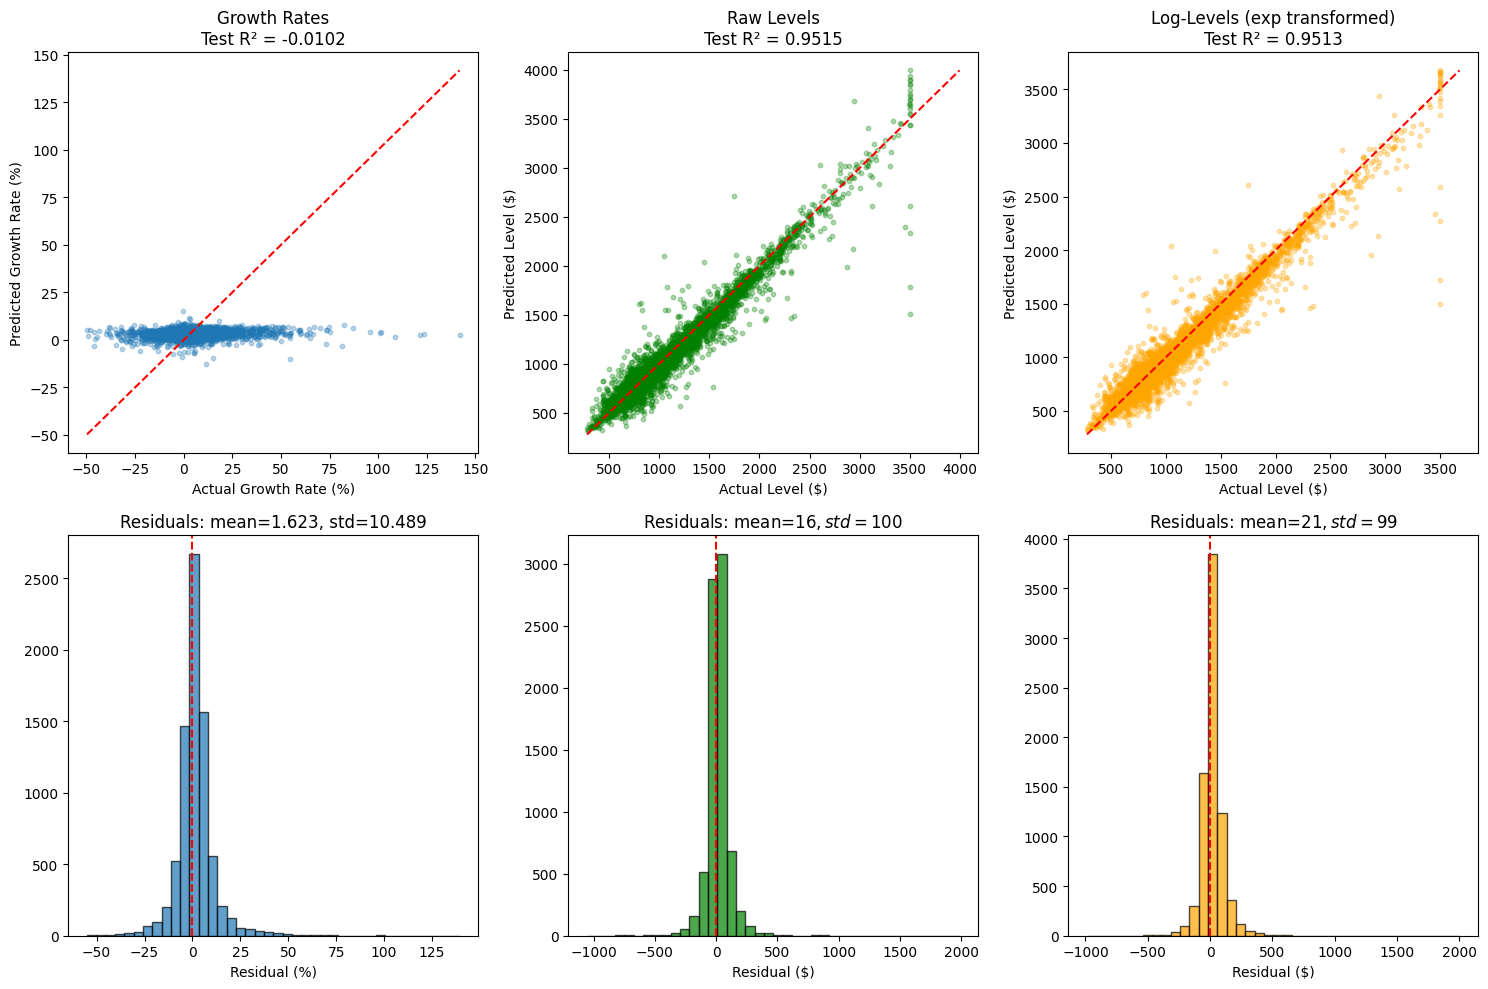

In [44]:
# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Actual vs Predicted (Test set)
# Growth rates
axes[0, 0].scatter(y_test_growth, y_pred_test_growth, alpha=0.3, s=10)
lims = [min(y_test_growth.min(), y_pred_test_growth.min()), max(y_test_growth.max(), y_pred_test_growth.max())]
axes[0, 0].plot(lims, lims, 'r--')
axes[0, 0].set_xlabel('Actual Growth Rate (%)')
axes[0, 0].set_ylabel('Predicted Growth Rate (%)')
axes[0, 0].set_title(f'Growth Rates\nTest R² = {growth_results["test_r2"]:.4f}')

# Raw levels
axes[0, 1].scatter(y_test_level, y_pred_test_level, alpha=0.3, s=10, color='green')
lims = [min(y_test_level.min(), y_pred_test_level.min()), max(y_test_level.max(), y_pred_test_level.max())]
axes[0, 1].plot(lims, lims, 'r--')
axes[0, 1].set_xlabel('Actual Level ($)')
axes[0, 1].set_ylabel('Predicted Level ($)')
axes[0, 1].set_title(f'Raw Levels\nTest R² = {level_results["test_r2"]:.4f}')

# Log-levels (in original scale)
axes[0, 2].scatter(y_test_level_from_log, y_pred_test_log_exp, alpha=0.3, s=10, color='orange')
lims = [min(y_test_level_from_log.min(), y_pred_test_log_exp.min()), max(y_test_level_from_log.max(), y_pred_test_log_exp.max())]
axes[0, 2].plot(lims, lims, 'r--')
axes[0, 2].set_xlabel('Actual Level ($)')
axes[0, 2].set_ylabel('Predicted Level ($)')
axes[0, 2].set_title(f'Log-Levels (exp transformed)\nTest R² = {log_results_original_scale["test_r2"]:.4f}')

# Row 2: Residual distributions
# Growth rates
resid_growth = y_test_growth - y_pred_test_growth
axes[1, 0].hist(resid_growth, bins=40, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='red', linestyle='--')
axes[1, 0].set_xlabel('Residual (%)')
axes[1, 0].set_title(f'Residuals: mean={resid_growth.mean():.3f}, std={resid_growth.std():.3f}')

# Raw levels
resid_level = y_test_level - y_pred_test_level
axes[1, 1].hist(resid_level, bins=40, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].axvline(x=0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Residual ($)')
axes[1, 1].set_title(f'Residuals: mean=${resid_level.mean():,.0f}, std=${resid_level.std():,.0f}')

# Log-levels (in original scale)
resid_log_exp = y_test_level_from_log - y_pred_test_log_exp
axes[1, 2].hist(resid_log_exp, bins=40, edgecolor='black', alpha=0.7, color='orange')
axes[1, 2].axvline(x=0, color='red', linestyle='--')
axes[1, 2].set_xlabel('Residual ($)')
axes[1, 2].set_title(f'Residuals: mean=${resid_log_exp.mean():,.0f}, std=${resid_log_exp.std():,.0f}')

plt.tight_layout()
plt.show()

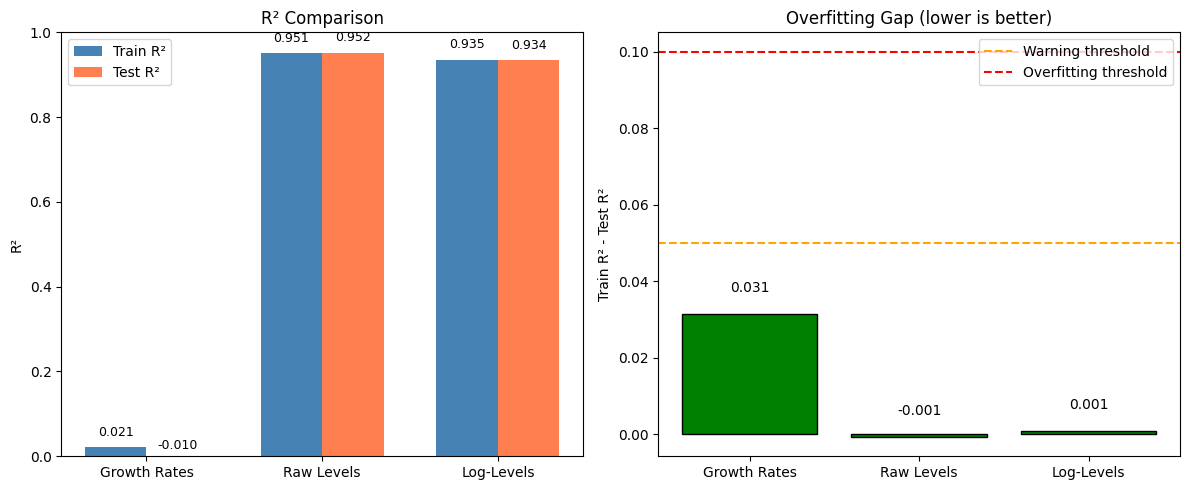

In [45]:
# Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

approaches = ['Growth Rates', 'Raw Levels', 'Log-Levels']
train_r2 = [growth_results['train_r2'], level_results['train_r2'], log_results['train_r2']]
test_r2 = [growth_results['test_r2'], level_results['test_r2'], log_results['test_r2']]

x = np.arange(len(approaches))
width = 0.35

# R² comparison
bars1 = axes[0].bar(x - width/2, train_r2, width, label='Train R²', color='steelblue')
bars2 = axes[0].bar(x + width/2, test_r2, width, label='Test R²', color='coral')
axes[0].set_ylabel('R²')
axes[0].set_title('R² Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(approaches)
axes[0].legend()
axes[0].set_ylim(0, 1)

# Add value labels
for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)

# Overfitting gap
gaps = [t - e for t, e in zip(train_r2, test_r2)]
colors = ['green' if g < 0.05 else 'orange' if g < 0.1 else 'red' for g in gaps]
bars = axes[1].bar(approaches, gaps, color=colors, edgecolor='black')
axes[1].set_ylabel('Train R² - Test R²')
axes[1].set_title('Overfitting Gap (lower is better)')
axes[1].axhline(y=0.05, color='orange', linestyle='--', label='Warning threshold')
axes[1].axhline(y=0.1, color='red', linestyle='--', label='Overfitting threshold')
axes[1].legend()

for bar, gap in zip(bars, gaps):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{gap:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Key Insights

In [ ]:
print("\n" + "=" * 70)
print("KEY INSIGHTS")
print("=" * 70)

# Find best approach
test_r2_all = {
    'Growth Rates': growth_results['test_r2'],
    'Raw Levels': level_results['test_r2'],
    'Log-Levels': log_results['test_r2'],
}
best_approach = max(test_r2_all, key=test_r2_all.get)

print(f"\n1. BEST TEST R²: {best_approach} ({test_r2_all[best_approach]:.4f})")

print(f"\n2. WHY LEVELS/LOG-LEVELS HAVE HIGHER R²:")
print(f"   - Growth rates cluster near zero with low variance")
print(f"   - Levels have natural cross-sectional variation (expensive vs cheap cities)")
print(f"   - Persistence: expensive cities stay expensive, cheap stay cheap")

print(f"\n3. CAUTION WITH HIGH R² ON LEVELS:")
print(f"   - High R² can be misleading - it's 'easy' to predict next year ≈ this year")
print("   - Check if model beats naive baseline: predict y_t = y_{t-1}")

# Compute naive baseline for RAW LEVELS
naive_pred_level = test_df[f'{outcome}_level_lag1'].values
naive_r2_level = r2_score(y_test_level, naive_pred_level)
naive_rmse_level = np.sqrt(mean_squared_error(y_test_level, naive_pred_level))

# Compute naive baseline for LOG-LEVELS
naive_pred_log = test_df[f'{outcome}_log_lag1'].values  # log(y_{t-1})
naive_r2_log = r2_score(y_test_log, naive_pred_log)
naive_rmse_log = np.sqrt(mean_squared_error(y_test_log, naive_pred_log))

# Also compute log naive baseline in original scale
naive_pred_log_exp = np.exp(naive_pred_log)
naive_r2_log_orig = r2_score(y_test_level_from_log, naive_pred_log_exp)
naive_rmse_log_orig = np.sqrt(mean_squared_error(y_test_level_from_log, naive_pred_log_exp))

print("\n4. NAIVE BASELINES (predict y_t = y_{t-1}):")
print(f"\n   RAW LEVELS:")
print(f"   Naive R²:                   {naive_r2_level:.4f}")
print(f"   Naive RMSE:                 ${naive_rmse_level:,.2f}")
print(f"   Model R²:                   {level_results['test_r2']:.4f}")
print(f"   Model improvement:          {(level_results['test_r2'] - naive_r2_level):.4f} R²")

print(f"\n   LOG-LEVELS (in log space):")
print(f"   Naive R²:                   {naive_r2_log:.4f}")
print(f"   Naive RMSE:                 {naive_rmse_log:.4f}")
print(f"   Model R²:                   {log_results['test_r2']:.4f}")
print(f"   Model improvement:          {(log_results['test_r2'] - naive_r2_log):.4f} R²")

print(f"\n   LOG-LEVELS (original scale):")
print(f"   Naive R²:                   {naive_r2_log_orig:.4f}")
print(f"   Naive RMSE:                 ${naive_rmse_log_orig:,.2f}")
print(f"   Model R²:                   {log_results_original_scale['test_r2']:.4f}")
print(f"   Model improvement:          {(log_results_original_scale['test_r2'] - naive_r2_log_orig):.4f} R²")

print(f"\n5. RECOMMENDATION:")
level_improvement = level_results['test_r2'] - naive_r2_level
log_improvement = log_results['test_r2'] - naive_r2_log

if max(level_improvement, log_improvement) > 0.01:
    print(f"   ✓ Model adds value over naive baseline")
    if log_improvement > level_improvement:
        print(f"   ✓ Log-levels show better improvement ({log_improvement:.4f}) vs raw levels ({level_improvement:.4f})")
    else:
        print(f"   ✓ Raw levels show better improvement ({level_improvement:.4f}) vs log-levels ({log_improvement:.4f})")
else:
    print(f"   ⚠ Model barely beats naive baseline")
    print(f"   ⚠ High R² is driven by persistence, not true forecasting skill")


KEY INSIGHTS

1. BEST TEST R²: Raw Levels (0.9515)

2. WHY LEVELS/LOG-LEVELS HAVE HIGHER R²:
   - Growth rates cluster near zero with low variance
   - Levels have natural cross-sectional variation (expensive vs cheap cities)
   - Persistence: expensive cities stay expensive, cheap stay cheap

3. CAUTION WITH HIGH R² ON LEVELS:
   - High R² can be misleading - it's 'easy' to predict next year ≈ this year
   - Check if model beats naive baseline: predict y_t = y_{t-1}

4. NAIVE BASELINE (predict level_t = level_{t-1}):
   Naive R²: 0.9400
   Naive RMSE: $112.37
   Model improvement over naive: 0.0115 R²

5. RECOMMENDATION:
   ✓ Model adds value over naive baseline
   ✓ Consider using log-levels for better distributional properties
